# Финальный вариант построения моделей для отзывов о мультфильмах с Кинопоиска

База данных для обучения моделей состоит из отзывов на различные мультфильмы, опубликованных на "Кинопоиске" в разные периоды с разными оценками. Задача, которую выстраиваемые модели должны решать, - рекомендация типа рецензии на основе текста: положительная/нейтральная или отрицательная. 

In [1]:
# Библиотеки для работы с табличными данными
import json

import numpy as np
import pandas as pd 

# Библиотеки для визуализации данных 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud

# Библиотеки для работы с текстами 
import nltk
import gensim.downloader as api

# Библиотеки для построения моделей
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# Вспомогательные библиотеки 
from tqdm import tqdm 
from joblib import dump, load
from scipy.stats import uniform

In [2]:
import preprocessing_text

In [3]:
init_notebook_mode(connected=True)
tqdm.pandas()

## Обзор данных

Выборка мультфильмов формировалась случайным образом и на основе некоторых рейтингов на разных сайтах в интернете, найденным в том числе по запросам "топ лучших" и "топ худших" мультфильмов, таким образом, чтобы включать в себя как положительные, так и нейтральные и отрицательные опубликованные на сайте рецензии. Данные собирались 8-9 июня 2024. Ниже приведён более подробный обзор данных, составляющих базу для исследования и построения моделей. 

In [110]:
data = pd.read_csv('data/kinopoisk_db_240609.csv')
data['comment_date'] = pd.to_datetime(data['comment_date'])
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860 entries, 0 to 5859
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   comment_id               5860 non-null   int64         
 1   comment_date             5860 non-null   datetime64[ns]
 2   comment_link             5593 non-null   object        
 3   comment_kind             5860 non-null   object        
 4   comment_heading          4822 non-null   object        
 5   comment_text             5860 non-null   object        
 6   comment_useful_positive  5860 non-null   int64         
 7   comment_useful_negative  5860 non-null   int64         
 8   movie_title              5860 non-null   object        
 9   movie_link               5860 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 457.9+ KB


In [111]:
data.head(5)

comment_id        comment_date  \
0     2521975 2017-04-03 14:15:00   
1     2406954 2016-06-04 14:42:00   
2     2394518 2016-04-29 21:11:00   
3     2382257 2016-03-31 10:39:00   
4     2382256 2016-03-31 10:36:00   

                                              comment_link comment_kind  \
0  https://www.kinopoisk.ru/user/13978783/comment/2521975/          bad   
1   https://www.kinopoisk.ru/user/5082013/comment/2406954/          bad   
2   https://www.kinopoisk.ru/user/2375715/comment/2394518/          bad   
3   https://www.kinopoisk.ru/user/5942545/comment/2382257/         good   
4   https://www.kinopoisk.ru/user/2893306/comment/2382256/          bad   

                                   comment_heading  \
0                                              NaN   
1          Много 'писелей' и никакого удовольствия   
2  Отличный мультфильм для всей семьи? Сомневаюсь.   
3                     Гордость за поднятие планки!   
4                           До утки на пятые сутки   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Посмотрим на объём выборки: какие фильмы в неё включены, сколько отзывов есть на каждый фильм и соотношение классов в них. 

In [112]:
movie_stats = pd.pivot_table(data=data, index='movie_title', aggfunc={
    'comment_id': 'count', 
    'comment_kind': [lambda x: (x == 'bad').sum(), lambda x: (x == 'neutral').sum(), lambda x: (x == 'good').sum()],
})
movie_stats.columns = ['total', 'bad', 'neutral', 'good']
movie_stats.sort_values(by='total', ascending=False, inplace=True)

fig = px.bar(data_frame=movie_stats, x=movie_stats.index, y=['bad', 'neutral', 'good'], 
             width=1200, height=800, 
             hover_name=movie_stats.index,
             labels={'movie_title': 'Название фильма', 'value': 'Количество'},
             title='Количество отзывов по фильмам', 
             color_discrete_sequence=['#fc7042', '#d8e0d7', '#5bace3']
       )

newnames = {'bad': 'Негативный', 'neutral': 'Нейтральный', 'good': 'Позитивный', '': ''}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name], legendgroup = newnames[t.name], hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig.update_layout(xaxis=go.layout.XAxis(showticklabels=False, visible=False))
iplot(fig)

Количество комментариев к фильмам сильно разнится, и наиболее популярные фильмы вносят, как правило, больше положительных отзывов, чем отрицательных (исключение - "Наша Маша и Волшебный орех", "Миньоны", "Ледниковый период: Столкновение неизбежно", "Гадкий я 3", "Шрэк Третий", "Приключения Алёнушки и Ерёмы", "Кукурача"). Ключевая характеристика данных - соотношение разных классов, на основе которых планируется обучать модель. Целевая переменная - `comment_kind`. Посмотрим на среднее соотношение количества разных отзывов в каждом фильме, чтобы оценить репрезентативность выборки в целом.

In [113]:
print(f"В среднем доля положительных отзывов среди всех: {((movie_stats['good'] / movie_stats['total']).mean() * 100).round(2)} %")
print(f"В среднем доля нейтральных отзывов среди всех: {((movie_stats['neutral'] / movie_stats['total']).mean() * 100).round(2)} %")
print(f"В среднем доля негативных отзывов среди всех: {((movie_stats['bad'] / movie_stats['total']).mean() * 100).round(2)} %")

В среднем доля положительных отзывов среди всех: 57.31 %
В среднем доля нейтральных отзывов среди всех: 17.66 %
В среднем доля негативных отзывов среди всех: 25.03 %


Теперь посмотрим на те же доли в имеющихся данных.

In [114]:
kind_stats = pd.pivot_table(data=data, index='comment_kind', aggfunc={'comment_id': [lambda x: x.count() / data.shape[0], 'count']})
kind_stats.columns = ['relative', 'absolute']
kind_stats.sort_values(by='relative', ascending=False, inplace=True)

fig = px.pie(kind_stats, names=kind_stats.index, values='relative', width=500, height=500, hover_name=kind_stats.index, hover_data=None,
             labels={'relative': 'Доля отзывов среди всех', 'comment_kind': 'Тип отзыва', 'absolute': 'Абсолютное число отзывов'}, 
             title='Соотношение типов отзывов в данных'
)
iplot(fig)

Выборка явно скошена в сторону позитивных отзывов даже относительно соотношения отзывов в фильмах, поэтому при обучении модели нужно будет балансировать классы между собой, чтобы не допустить переобучения. При этом выборка включает в себя все три класса, это уже хорошо, и отражает доминирование позитивных комментариев. 

Наконец, посмотрим на временной разброс комментариев. Сгруппируем их по дате. 

In [115]:
dates_stats = data.groupby(data.comment_date.dt.date)['comment_id'].count().to_frame()

In [116]:
fig = px.line(data_frame=dates_stats, x=dates_stats.index, y='comment_id', title='Количество отзывов по датам', 
              labels={'comment_id': 'Количество отзывов', 'comment_date': 'Дата публикации отзыва'})
iplot(fig)

Как видно, в наборе данных большая часть комментариев написана в 2010-х годах, но встречаются и как более ранние (начиная с 2006) и более поздние (написанные в 2020-х годах). В целом, достаточно высокая вариативность. 

## Предварительная обработка данных

Задача предварительной обработки данных - привести сырые текстовые данные к такому виду, который сможет "переварить" модель машинного обучения. Так как работа проводится с текстами, их нужно векторизовать. Но перед векторизацией необходимо провести их очистку, чтобы в них не встречались лишние знаки и прочий мусор, стоп-слова и т.д. Это всё впоследствии скажется на работе модели. 

### Слияние текстовых переменных 

Для начала объединим два текстовых поля в одно: заголовок и основной текст. 

In [117]:
data['full_text'] = data.apply(lambda x: ' '.join([x['comment_heading'], x['comment_text']]) if not pd.isna(x['comment_heading']) else x['comment_text'], axis=1)

In [118]:
data.drop(columns=['comment_heading', 'comment_text'], inplace=True)

### Токенизация и очистка от стоп-слов

Теперь применим к каждому тексту функцию-обработчик для получения избавленного от знаков препинания и недопустимых символов текста в нижнем регистре. 

In [119]:
data['full_text'] = data['full_text'].apply(preprocessing_text.preprocess_text)

Создадим список стоп-слов для фильтрации токенов и переведём все тексты в токены с учётом этого списка стоп-слов. 

In [120]:
stop_words = nltk.corpus.stopwords.words('russian')
for word in ['никогда', 'наконец', 'ничего', 'совсем', 'только', 'почти', 'сейчас', 'впрочем', 
             'хорошо', 'нельзя', 'всегда', 'конечно']:
    if word in stop_words:
        stop_words.remove(word)
        
stop_words.extend(['это', 'мультфильм', 'ребенок', 'фильм', 'мультик', 'свой', 'весь', 'все', 'еще', 'очень', 'который', 'человек', 'только', 'просто',
                   'сюжет', 'мочь', 'хороший', 'персонаж', 'смотреть', 'история'])

In [121]:
data['tokens'] = data['full_text'].progress_apply(lambda x: preprocessing_text.tokenize_text(x, stop_words))

100%|██████████| 5860/5860 [02:15<00:00, 43.18it/s]


Построим по получившимся токенам облако слов, чтобы определить, не осталось ли каких-либо стоп-слов, которые нужно включить в список.

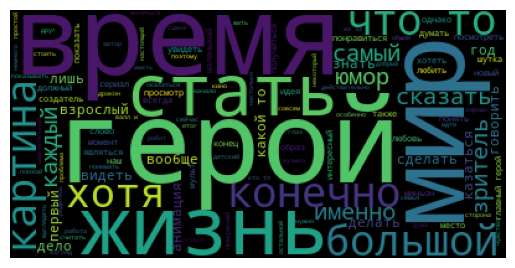

In [122]:
wc = WordCloud().generate(' '.join(data['tokens'].apply(lambda x: ' '.join(x))))
plt.imshow(wc)
plt.axis('off');

Посмотрим на соотношение количества токенов в отзыве и его относительную полезность. 

In [123]:
data['useful_rel'] = data['comment_useful_positive'] / (data['comment_useful_positive'] + data['comment_useful_negative'])

fig = px.scatter(data, x=data['tokens'].apply(len), y='useful_rel', color='comment_kind', 
                 labels={'x': 'Количество токенов', 'useful_rel': 'Относительная полезность', 'comment_kind': 'Вид отзыва'}, 
                 title='Относительная полезность отзыва vs Количество токенов в отзыве', 
                 color_discrete_sequence=['#fc7042', '#5bace3', '#d8e0d7'], 
                 opacity=0.6)
newnames = {'bad': 'Негативный', 'neutral': 'Нейтральный', 'good': 'Позитивный', '': ''}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name], legendgroup = newnames[t.name], hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
iplot(fig)

Образуется непонятное облако точек, исходя из которого понятно лишь, что большая часть отзывов содержит < 400 токенов. 

### Векторизация текста 

Для векторизации текста будем использовать Word2Vec, уже существующую модель, обученную на корпусе русских слов. Для начала немного урежем данные, которые есть сейчас: уберём из них всё, что не связано с токенам и целевой переменной. 

In [124]:
vector_data = data[['tokens', 'comment_kind']].copy()

In [125]:
vector_data.to_pickle('data/tokens.pickle')

In [126]:
vector_data = pd.read_pickle('data/tokens.pickle')

Загружаем предобученную модель Word2Vec.

In [127]:
wv = api.load('word2vec-ruscorpora-300')

В текстах не указаны части речи, а вот в предобученной модели в ключах они содержатся. Чтобы избежать сложностей, создадим словарь с соотношением между просто словом и ключом этого слова в модели - он будет использоваться при векторизации. 

In [128]:
vocab_to_vocab_parts = dict([(k.split('_')[0], k) for k in wv.index_to_key])

with open('data/vocab_parts.json', 'w') as f:
    json.dump(vocab_to_vocab_parts, f, ensure_ascii=False, indent=4)

In [129]:
with open('data/vocab_parts.json') as f:
    vocab_to_vocab_parts = json.load(f)

Проводим векторизацию текста. 

In [130]:
vector_data['vector'] = vector_data['tokens'].progress_apply(lambda x: preprocessing_text.vectorize_text(tokens=x, model=wv, parts_dict=vocab_to_vocab_parts, vector_size=300))

100%|██████████| 5860/5860 [00:01<00:00, 5072.44it/s]


Сохраняем вектора и целевую переменную в новый файл.

In [131]:
vector_data = pd.concat([pd.DataFrame(vector_data['vector'].to_list()), vector_data['comment_kind']], axis=1)

In [132]:
vector_data.to_csv('data/vectors.csv', index=False)

In [133]:
vector_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,comment_kind
0,-0.001584,-0.000007,0.013450,0.030858,-0.007453,0.018740,0.004009,0.020514,0.001892,-0.021259,...,0.012159,-0.006921,0.004910,-0.015766,-0.025661,0.020865,0.034991,-0.019136,0.011228,bad
1,-0.005330,0.001286,0.014146,0.037177,-0.013040,0.006857,-0.008692,0.007154,-0.000580,-0.005008,...,0.011437,-0.006339,0.007985,-0.023670,-0.037996,0.023521,0.031363,-0.016872,0.007026,bad
2,0.002575,0.021930,0.017132,0.022403,-0.012974,0.013518,-0.014841,0.017061,-0.009443,-0.009492,...,0.013207,-0.013233,0.001223,-0.024457,-0.043031,0.029261,0.024970,-0.017618,-0.001527,bad


In [134]:
print(f'Размерность вектора: {vector_data.shape[1] - 1}')
print(f'Количество векторов: {vector_data.shape[0]}')

Размерность вектора: 300
Количество векторов: 5860


## Построение моделей

Предположим, что мы как создатели мультфильмов хотим исследовать ошибки других авторов и пользовательское мнение о продуктах других компаний. В таком случае нам ценны негативные и нейтральные комментарии как один класс, содержащий недостатки других продуктов, и позитивные комментарии - мнения о позитивных практиках и характеристиках других фильмов. В таком случае мы можем объединить классы bad и neutral в одну категорию, противостоящую good.

Всего в выборке содержится 5860 наблюдений, причём в них наблюдается дисбаланс по типам комментариев: 70% позитивных комментариев против 30% другой группы. Для качественного обучения модели придётся компенсировать этот дисбаланс методами оверсемплинга, но это применимо только тренировочным данным (чтобы тестовые данные оставались оригинальными и на тестах модель показывала реальные результаты). Всего построим две модели: случайный лес и модель ядерного метода опорных векторов. 

### Подготовка выборки

Разделим выборку на тренировочную и тестовую в соотношении 90:10. Тестовая такая маленькая, так как из тренировочной мы ещё выделим валидационную. 

In [255]:
vector_data = pd.read_csv('data/vectors.csv')

Переведём показатель типа комментария в бинарную переменную: 0 - негативно-нейтральная, 1 - позитивная.

In [256]:
comment_kinds = {'bad': 0, 'neutral': 0, 'good': 1}
vector_data['comment_kind'] = vector_data['comment_kind'].map(comment_kinds)

In [257]:
train_x, test_x, train_y, test_y = train_test_split(vector_data.drop(columns=['comment_kind']), vector_data['comment_kind'], 
                                                    test_size=0.1, random_state=42, shuffle=True, stratify=vector_data['comment_kind'])

In [258]:
print(f'Тренировочный Х: {train_x.shape}')
print(f'Тренировочный Y: {train_y.shape}')
print(f'Тестовый X: {test_x.shape}')
print(f'Тестовый Y: {test_y.shape}')

Тренировочный Х: (5274, 300)
Тренировочный Y: (5274,)
Тестовый X: (586, 300)
Тестовый Y: (586,)


Сохраним и ту, и другую в файлы для воспроизведения результатов.

In [259]:
train_x.to_csv('data/train_x.csv', index=False)
train_y.to_csv('data/train_y.csv', index=False)
test_x.to_csv('data/test_x.csv', index=False)
test_y.to_csv('data/test_y.csv', index=False)

In [4]:
train_x = pd.read_csv('data/train_x.csv')
train_y = pd.read_csv('data/train_y.csv')['comment_kind']

Из тренировочной выборки выделим 30% валидационной выборки. 

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.3, random_state=42, shuffle=True, stratify=train_y)

Тренировочную выборку приведём к балансу классов. 

In [6]:
oversampler = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
train_x, train_y = oversampler.fit_resample(train_x, train_y)

In [7]:
print(f'Тренировочный Х после овесемплинга: {train_x.shape}')
print(f'Тренировочный Y после овесемплинга: {train_y.shape}')

Тренировочный Х после овесемплинга: (5283, 300)
Тренировочный Y после овесемплинга: (5283,)


Теперь соотношение классов сопоставимое и модель не должна при обучении перекашиваться в сторону позитивных комментариев только потому, что их больше в выборке. 

In [8]:
train_y.value_counts()

comment_kind
0    2692
1    2591
Name: count, dtype: int64

### Нормализация векторов

Применим к векторам нормализацию - сделаем их такими, чтобы вектор = 1.

In [357]:
normalizer = Normalizer()
train_x = normalizer.fit_transform(train_x)

In [9]:
normalizer = load('pretrained_models/normalizer.joblib')
train_x = normalizer.transform(train_x)

Сохраним нормализатор в файл для дальнейшего использования.

In [358]:
dump(normalizer, 'pretrained_models/normalizer.joblib')

['pretrained_models/normalizer.joblib']

### Уменьшение размерности

Вектор в 300 значений - это хорошо, но все ли компоненты в нём нужны? Построим PCA без ограничения в количество компонент, чтобы посмотреть на вклад каждой компоненты в объяснение общей дисперсии данных, и определим необходимое количество компонент. 

In [359]:
pca = PCA()
pca.fit(train_x)

explained_variance = pd.DataFrame(pca.explained_variance_ratio_)
explained_variance.columns = ['explained_variance']
explained_variance_cumsum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))
explained_variance_cumsum.columns = ['explained_variance']

In [360]:
fig = make_subplots(1, 2, subplot_titles=['Вклад компонент<br>в объяснение дисперсии данных', 'Кумулятивная сумма<br>объяснённой дисперсии данных'])
fig.add_trace(
    go.Scatter(x=explained_variance.index, y=explained_variance['explained_variance']), 
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=explained_variance_cumsum.index, y=explained_variance_cumsum['explained_variance']), 
    row=1, col=2
)
fig.update_layout(showlegend=False)
iplot(fig)

In [361]:
explained_variance_cumsum[explained_variance_cumsum > 0.9].dropna().head(5)

,explained_variance
162,0.900635
163,0.901779
164,0.902916
165,0.904050
166,0.905170


Первые 164 компоненты описывают 90% дисперсии данных. При этом вклад каждой следующей компоненты незначительный, поэтому можно уменьшить размерность вектора до 164 компонент.

In [362]:
pca_trained = PCA(n_components=164)
train_x = pca_trained.fit_transform(train_x)

Сохраним обученный объект PCA в файл для дальнейшего использования.

In [363]:
dump(pca_trained, 'pretrained_models/pca.joblib')

['pretrained_models/pca.joblib']

In [10]:
pca_trained = load('pretrained_models/pca.joblib')
train_x = pca_trained.transform(train_x)

### Проверка отделимости признаков друг от друга

Построим двухмерную визуализацию данных для определения того, насколько признаки отделимы друг от друга. Для этого построим модель линейного дискриминантного анализа с уменьшением размерности до 1 компоненты (количество классов = 2 => максимально возможное количество компонент в ЛДА = 2 - 1 = 1). Визуализация распределения классов позволит оценить отделимость признаков друг от друга. 

In [364]:
lda_2 = LinearDiscriminantAnalysis(n_components=1)

lda_2_x = pd.DataFrame(lda_2.fit_transform(train_x, train_y))
lda_2_x.columns = ['Component 1']
fig = px.scatter(lda_2_x, x='Component 1', color=train_y.apply(str), color_discrete_sequence=['#5bace3', '#fc7042'], width=600, height=600, title='LDA 1 component', opacity=0.7)

iplot(fig)

В 1-мерном пространстве Component 1 классы образуют два скученных облака, которые частично накладываются друг на друга. В целом данные отделимы, однако негативно-нейтральные отзывы накладываются на позитивные: вероятнее всего, это связано с близостью нейтральных отзывов из группы 0 к позитивным из группы 1. Вполне вероятно, что при добавлении ещё одного измерения окажется, что данные чуть лучше отделимы друг от друга. 

### Применение всех изменений к валидационной выборке 

В валидационной выборке сохранены изначальные соотношения классов. 

In [11]:
normalizer = load('pretrained_models/normalizer.joblib')
pca = load('pretrained_models/pca.joblib')

In [12]:
norm_pca_pipe = Pipeline([('normalizer', normalizer), ('pca', pca)])

In [13]:
valid_x = norm_pca_pipe.transform(valid_x)

In [14]:
valid_y.value_counts()

comment_kind
1    1111
0     472
Name: count, dtype: int64

### Построение модели случайного леса

Подбор гиперпараметров проводится в два этапа: сначала подбираются рандомным образом лучшие диапазоны, затем более точно подбираются гиперпараметры в диапазонах с помощью сетки. В качестве параметра criterion поставим критерий gini: он склонен к тому, чтобы отделять классы в отдельные ветви, тогда как энтропия стремится к созданию более сбалансированного класса. Также зафиксируем random_state = 42, чтобы была воспроизводимость результатов. 

Посчитаем веса классов в несбалансированной выборке

In [15]:
weights = dict(enumerate(compute_class_weight('balanced', classes=train_y.unique(), y=train_y)))
weights

{0: 0.9812407132243685, 1: 1.019490544191432}

Построим сетку для подбора параметров.

In [424]:
params_random_grid = dict(
    n_estimators=np.arange(100, 1101, 200), 
    criterion=['gini'],
    max_depth=np.arange(10, 1511, 200),
    min_samples_split=np.arange(5, 11, 2),
    min_samples_leaf=np.arange(1, 11, 2),
    bootstrap=[False, True],
    class_weight=[weights],
    random_state=[42],
)

random_forest_clean = RandomForestClassifier()
random_searcher = HalvingGridSearchCV(random_forest_clean, param_grid=params_random_grid, cv=3, n_jobs=4, verbose=1, scoring='accuracy', factor=5, min_resources=200, 
                                      aggressive_elimination=True)

Проверим каждую комбинацию параметров по 3 раза. 

In [425]:
%%time
random_searcher.fit(train_x, train_y)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 200
max_resources_: 5283
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 1440
n_resources: 200
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
----------
iter: 1
n_candidates: 288
n_resources: 200
Fitting 3 folds for each of 288 candidates, totalling 864 fits
----------
iter: 2
n_candidates: 58
n_resources: 200
Fitting 3 folds for each of 58 candidates, totalling 174 fits
----------
iter: 3
n_candidates: 12
n_resources: 1000
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 4
n_candidates: 3
n_resources: 5000
Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 1min, sys: 640 ms, total: 1min 1s
Wall time: 11min 38s


HalvingGridSearchCV(aggressive_elimination=True, cv=3,
                    estimator=RandomForestClassifier(), factor=5,
                    min_resources=200, n_jobs=4,
                    param_grid={'bootstrap': [False, True],
                                'class_weight': [{0: 0.9812407132243685,
                                                  1: 1.019490544191432}],
                                'criterion': ['gini'],
                                'max_depth': array([  10,  210,  410,  610,  810, 1010, 1210, 1410]),
                                'min_samples_leaf': array([1, 3, 5, 7, 9]),
                                'min_samples_split': array([5, 7, 9]),
                                'n_estimators': array([ 100,  300,  500,  700,  900, 1100]),
                                'random_state': [42]},
                    scoring='accuracy', verbose=1)

Оценим результаты.

In [426]:
rgs_results = pd.DataFrame(random_searcher.cv_results_).sort_values(by=['rank_test_score'])

In [427]:
linear = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf']
categorical = ['param_bootstrap']
columns = 3
rows = int(np.ceil(len(linear + categorical) // columns)) + 1

fig = make_subplots(rows, columns, y_title='Precision', x_title='Parameter value', shared_yaxes=False, subplot_titles=linear + categorical)

column = 1
row = 1

for param in linear:
    t = rgs_results.groupby(param)['mean_test_score'].mean()
    f = go.Scatter(x=t.index, y=t.values, name=param)
    fig.add_trace(f, col=column, row=row)
    column += 1
    if column == columns + 1:
        column = 1
        row += 1

for param in categorical:
    t = rgs_results.groupby(param)['mean_test_score'].mean()
    f = go.Bar(x=t.index, y=t.values, name=param)
    fig.add_trace(f, col=column, row=row)
    column += 1
    if column == columns + 1:
        column = 1
        row += 1

fig.update_layout(showlegend=False, width=1200, height=800)

В результате образуется следующий набор параметров:

In [440]:
forest_params = {
    'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': weights,
    'criterion': 'gini',
    'max_depth': 1010,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 5,
    'min_samples_split': 7,
    'min_weight_fraction_leaf': 0.0,
    'monotonic_cst': None,
    'n_estimators': 500,
    'n_jobs': 1,
    'oob_score': False,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False
}

Обучим модель в соответствии с этими параметрами.

In [441]:
random_forest = RandomForestClassifier(**forest_params)

In [442]:
random_forest.fit(train_x, train_y)

RandomForestClassifier(class_weight={0: 0.9812407132243685,
                                     1: 1.019490544191432},
                       max_depth=1010, min_samples_leaf=5, min_samples_split=7,
                       n_estimators=500, n_jobs=1, random_state=42)

In [42]:
forest_pred_valid_y = random_forest.predict(valid_x)

In [43]:
print(classification_report(valid_y, forest_pred_valid_y, digits=4))

              precision    recall  f1-score   support

           0     0.6746    0.4788    0.5601       472
           1     0.8029    0.9019    0.8495      1111

    accuracy                         0.7757      1583
   macro avg     0.7388    0.6904    0.7048      1583
weighted avg     0.7646    0.7757    0.7632      1583



Точность (precision) модели - 0.74, причём показатель для позитивных комментариев значительно выше показателя для отрицательного. В целом предсказания модели имеют практический смысл: несмотря на небольшой дисбаланс в обучающей выборке, минимальное значение accuracy должно быть выше 55%. Accuracy же этой модели на валидационной выборке - 78%, что явно выше нижнего порога. Остановимся на текущем наборе параметров и сохраним модель в файл для дальнейшего использования. 

In [445]:
dump(random_forest, 'pretrained_models/random_forest.joblib')

['pretrained_models/random_forest.joblib']

### Построение модели ядерного метода опорных векторов

Обозначим сетку параметров для подбора.

In [16]:
params_grid = dict(
    C=np.arange(0.5, 1.0, 0.1), 
    kernel=['rbf'],
    gamma=np.arange(1.0, 10.0, 0.2),
    tol=np.arange(1e-5, 1e-4, 5e-6),
    class_weight=[weights],
    max_iter=np.arange(5000, 11000, 1000), 
    random_state=[42],
)

In [17]:
svc_clean = SVC()
random_searcher_svc = HalvingGridSearchCV(svc_clean, param_grid=params_grid, cv=3, n_jobs=4, verbose=1, scoring='accuracy', factor=3, min_resources=500, 
                                      aggressive_elimination=True)

Проверим возможные параметры

In [18]:
%%time
random_searcher_svc.fit(train_x, train_y)

n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 3
min_resources_: 500
max_resources_: 5283
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 24300
n_resources: 500
Fitting 3 folds for each of 24300 candidates, totalling 72900 fits
----------
iter: 1
n_candidates: 8100
n_resources: 500
Fitting 3 folds for each of 8100 candidates, totalling 24300 fits
----------
iter: 2
n_candidates: 2700
n_resources: 500
Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
----------
iter: 3
n_candidates: 900
n_resources: 500
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
----------
iter: 4
n_candidates: 300
n_resources: 500
Fitting 3 folds for each of 300 candidates, totalling 900 fits
----------
iter: 5
n_candidates: 100
n_resources: 500
Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------
iter: 6
n_candidates: 34
n_resources: 500
Fitting 3 folds for each of 34 candidates, totalling 102 fits
----------
iter: 7
n_

HalvingGridSearchCV(aggressive_elimination=True, cv=3, estimator=SVC(),
                    min_resources=500, n_jobs=4,
                    param_grid={'C': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                'class_weight': [{0: 0.9812407132243685,
                                                  1: 1.019490544191432}],
                                'gamma': array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
       3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. , 5.2, 5.4, 5.6, 5.8, 6. ,
       6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6, 7.8, 8. , 8.2, 8.4, 8.6,
       8.8, 9. , 9.2, 9.4, 9.6, 9.8]),
                                'kernel': ['rbf'],
                                'max_iter': array([ 5000,  6000,  7000,  8000,  9000, 10000]),
                                'random_state': [42],
                                'tol': array([1.0e-05, 1.5e-05, 2.0e-05, 2.5e-05, 3.0e-05, 3.5e-05, 4.0e-05,
       4.5e-05, 5.0e-05, 5.5e-05, 6.0e-05, 6.5e-05, 7.0e-05, 7.5e-05,
       8.0e-05, 8.5e-05, 9.0e-05, 9.5e-05])},
                    scoring='accuracy', verbose=1)

Оценим результаты

In [19]:
rgs_results = pd.DataFrame(random_searcher_svc.cv_results_).sort_values(by=['rank_test_score'])

In [20]:
linear = ['param_C', 'param_max_iter', 'param_tol', 'param_gamma']
categorical = []
columns = 3
rows = int(np.ceil(len(linear + categorical) // columns)) + 1

fig = make_subplots(rows, columns, y_title='Precision', x_title='Parameter value', shared_yaxes=False, subplot_titles=linear + categorical)

column = 1
row = 1

for param in linear:
    t = rgs_results.groupby(param)['mean_test_score'].mean()
    f = go.Scatter(x=t.index, y=t.values, name=param)
    fig.add_trace(f, col=column, row=row)
    column += 1
    if column == columns + 1:
        column = 1
        row += 1

for param in categorical:
    t = rgs_results.groupby(param)['mean_test_score'].mean()
    f = go.Bar(x=t.index, y=t.values, name=param)
    fig.add_trace(f, col=column, row=row)
    column += 1
    if column == columns + 1:
        column = 1
        row += 1

fig.update_layout(showlegend=False, width=1200, height=800)

В результате лучшим признаётся такой набор параметров:

In [32]:
svc_params = dict(
    C=0.9, 
    class_weight=weights,
    gamma=6.8, 
    kernel='rbf',
    max_iter=6000, 
    random_state=42, 
    tol=6e-5, 
)

Обучим модель в соответствии с этими параметрами

In [33]:
svc = SVC(**svc_params)

In [34]:
svc.fit(train_x, train_y)

SVC(C=0.9, class_weight={0: 0.9812407132243685, 1: 1.019490544191432},
    gamma=6.8, max_iter=6000, random_state=42, tol=6e-05)

In [35]:
svc_pred_valid_y = svc.predict(valid_x)

In [38]:
print(classification_report(valid_y, svc_pred_valid_y, digits=4))

              precision    recall  f1-score   support

           0     0.6764    0.7881    0.7280       472
           1     0.9032    0.8398    0.8703      1111

    accuracy                         0.8244      1583
   macro avg     0.7898    0.8140    0.7992      1583
weighted avg     0.8356    0.8244    0.8279      1583



Общий показатель precision для этой модели сопоставим с показателем случайного леса: 0.79 против 0.74. Получается, что ядерный метод опорных векторов чуть лучше справляется с задачей разделения классов за счёт формирования новых переменных и пространств и разделения данных в них. Более высокий результат модели связан с более высокой точностью определения позитивных комментариев, в то время как точность определения нейтрально-негативных сохраняется такой же, как и у модели случайного леса. 

Сохраним модель в файл для дальнейшего использования. 

In [37]:
dump(svc, 'pretrained_models/svc.joblib')

['pretrained_models/svc.joblib']